In [1]:
import fklab.analysis.core.context as con
import pandas as pd
import mat73

import h5py
from attentionAnalyses.utilities import get_files_path
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
context = con.AnalysisContext("/Volumes/nerfceph/farrowlabwip2024/Data/")
print(context.config.mouseIDs)
mouse_context = context['experiment/02275/type/headfixed/mouseID/m01']
paths = get_files_path(context, mouseIDs=['02203/m01'], sessionTypes = [''], fileTypes = ['CamPath'], OS = 'mac', root = '/Volumes/nerfceph/farrowlabwip2024/')
# # Convert to MATLAB array format
# array = "[ " + ", ".join(f'"{path}"' for path in paths) + " ]"

# # Print the result for MATLAB usage
# print(matlab_array)
paths[0]


['02203/m01', '02203/m02', '02275/m01', '02276/m01', '02277/m01', '02317/m01', '02318/m01', '02352/m01']
CamPath
Series([], Name: CamPath, dtype: object)


IndexError: list index out of range

In [23]:
stimData = mat73.loadmat(paths[0])

ERROR:root:ERROR: MATLAB type not supported: datetime, (uint32)
ERROR:root:ERROR: MATLAB type not supported: datetime, (uint32)
ERROR:root:ERROR: MATLAB type not supported: datetime, (uint32)
ERROR:root:ERROR: MATLAB type not supported: datetime, (uint32)
ERROR:root:ERROR: MATLAB type not supported: datetime, (uint32)
ERROR:root:ERROR: MATLAB type not supported: datetime, (uint32)
ERROR:root:ERROR: MATLAB type not supported: datetime, (uint32)
ERROR:root:ERROR: MATLAB type not supported: datetime, (uint32)
ERROR:root:ERROR: MATLAB type not supported: datetime, (uint32)


In [43]:
stimData.keys()

dict_keys(['ALI', 'ALIcorrect', 'ALIwrong', 'Background', 'BallCamData', 'BallCamTiming', 'CameraTiming', 'Frameinfo', 'LI', 'P', 'Pcorrect', 'Pwrong', 'RewardMode', 'StateOfAgentHistory', 'StimTime', 'StimulusColour', 'StimulusContrast', 'Tend', 'cue', 'cueLength', 'e', 'errorLicks', 'i', 'ifi', 'level', 'levelHistory', 'lickData', 'lickWindowMax', 'lickWindowMin', 'locationMode', 'maxErrorLicks', 'maxWait', 'minWait', 'options', 'postCueDelay', 'randomseed', 'redFrames', 'stimHistory', 'stimLocationHistory', 'stimLocationHistoryPX', 'stimdata', 'stimulusLicks', 'stimulusType', 'subsessions', 'subsessionwait', 'timeend', 'timestart', 'waitTimes', 'weight'])

In [24]:
stimData['subsessions']

array(9.)

In [50]:
stimData['options'].keys()



dict_keys(['Attention', 'Frameinfo', 'SetUp', 'Trialtsecbegin', 'addnote', 'full_screen_az', 'full_screen_el', 'maxintensity', 'projectortype', 'randomseed', 'red_sync_nth_frame', 'redintensity', 'relativeintensity', 'reset_rng_each_trial', 'specParams', 'stimulus_trial_t', 'timeend', 'timestart', 'trials', 'tsecbegin', 'tsecend', 'type', 'update_each_nth_frame', 'wait_col', 'wait_exit', 'wait_init', 'waitrange_between_trials'])

In [13]:
mouse_context.run('.run_dlc',parameters=dict(session='240712_1534'))

2025-04-29 11:02:12 | INFO | run_dlc experiment/02275/type/headfixed/mouseID/m01 | analysis, {'session': '240712_1534'}


/Volumes/nerfceph/farrowlabwip2024/Data/02275/headfixed/m01/analysis/run_dlc/session=240712_1534/v0
Elapsed time: 0.0342 seconds


In [37]:
session = "240712_1534"
statistic = 'median'

In [42]:
r = mouse_context.analysis[f"velocityAnalysis/session=240712_1534"].get().result

session=240712_1534


In [43]:
r['averageSpeedPerTrial']

<HDF5 group "/averageSpeedPerTrial" (5 members)>

In [30]:
func_map = {
    'mean': np.mean,
    'median': np.median
}
stimFileAnalysisResult = mouse_context.analysis[f"stimFileAnalysis/session={session}"].get().result
stimFileAnalysisInfo = mouse_context.analysis[f"stimFileAnalysis/session={session}"].get().info

frameRate = stimFileAnalysisInfo['analyze']['parameters']['frameRate']
secondsBefore = stimFileAnalysisInfo['analyze']['parameters']['secondsBefore']
secondsAfter = stimFileAnalysisInfo['analyze']['parameters']['secondsAfter']

behaviorData = stimFileAnalysisResult['behaviorData']
rewardedTrials = stimFileAnalysisResult['rewardedTrials']
nonRewardedTrials = stimFileAnalysisResult['nonRewardedTrials']
nonValidTrials = stimFileAnalysisResult['nonValidTrials']

movement = np.linalg.norm(behaviorData[1:,:,:], axis=0) # size of the total movement vector (cm/s)

#Calculate average speed in selected timewindows for different categories
nSubSessions = int(stimFileAnalysisResult['nSubsessions'][()])
nTrialsPerSubsession = int(stimFileAnalysisResult['nTrialsPerSubsession'][()])
trialCategories = ['rewarded', 'unrewarded'] + [f'subsession{i+1}' for i in np.arange(0,nSubSessions)]
trialCategoriesIndices = [rewardedTrials, nonRewardedTrials] + [np.arange(0,nTrialsPerSubsession+i*nTrialsPerSubsession) for i in np.arange(0,nSubSessions)]
#exclued invalid trials:
for i in range(len(trialCategoriesIndices)):
    trialCategoriesIndices[i] = [t for t in trialCategoriesIndices[i] if t not in nonValidTrials]
timeWindows = ['baseline', '3sPreStim', 'stim', '3sPostStim','aftermath']
timeWindowsSeconds = [
    [0, secondsBefore * frameRate],
    [3 * frameRate, secondsBefore * frameRate],
    [secondsBefore * frameRate, (secondsBefore+ 3) * frameRate],
    [(secondsBefore + 3) * frameRate, (secondsBefore + 6) * frameRate],
    [(secondsBefore + 3) * frameRate, None]  # None represents slicing to the end
]
avSpeedT= {}
avMovementT= {}
avSpeed= {}
avMovement= {}
for timeWindow, t in zip(timeWindows, timeWindowsSeconds):
    avSpeedT[timeWindow]={}
    avMovementT[timeWindow]={}
    avSpeed[timeWindow]={}
    avMovement[timeWindow]={}
    for cat, trialIdx in zip(trialCategories, trialCategoriesIndices):    
        avSpeedT[timeWindow][cat] = func_map[statistic](np.abs(behaviorData[1,t[0]:t[1],trialIdx]), axis=0) #only considering forward movement
        avMovementT[timeWindow][cat] = func_map[statistic](movement[t[0]:t[1],trialIdx],axis=0)
        avSpeed[timeWindow][cat] = func_map[statistic](avSpeedT[timeWindow][cat])
        avMovement[timeWindow][cat] = func_map[statistic](avMovementT[timeWindow][cat])

session=240526_1629
session=240526_1629


/Users/liesdeceuninck/miniconda3/envs/farrowlab/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/liesdeceuninck/miniconda3/envs/farrowlab/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [31]:
df = pd.DataFrame.from_dict(avMovement, orient='index')

In [32]:
# If your current index contains the timeWindow labels, reset it
df = df.reset_index().rename(columns={'index': 'timeWindow'})

# Melt to long format
df_long = pd.melt(df, id_vars='timeWindow', var_name='condition', value_name='value')

df_long

,timeWindow,condition,value
0,baseline,rewarded,3.629741
1,3sPreStim,rewarded,4.677084
2,stim,rewarded,0.796690
3,3sPostStim,rewarded,7.209211
4,aftermath,rewarded,3.137729
5,baseline,unrewarded,NaN
6,3sPreStim,unrewarded,NaN
7,stim,unrewarded,NaN
8,3sPostStim,unrewarded,NaN
9,aftermath,unrewarded,NaN


In [44]:
rows = []

for timeWindow in r['averageSpeedPerTrial']:
    for cat in r['averageSpeedPerTrial'][timeWindow]:
        # Assume the arrays are 1D: one value per subject/trial
        for i, (speed_val, movement_val) in enumerate(zip(r['averageSpeedPerTrial'][timeWindow][cat], r['averageMovementPerTrial'][timeWindow][cat])):
            rows.append({
                'timeWindow': timeWindow,
                'trialCategory': cat,
                'median speed (cm/s)': speed_val,
                'median movement (cm/s)': movement_val
            })

# Convert to DataFrame
df_long = pd.DataFrame(rows)

In [45]:
df_long

,timeWindow,trialCategory,av_speed,av_movement
0,3sPostStim,subsession1,10.56,67.746491
1,3sPostStim,subsession1,0.00,0.660000
2,3sPostStim,subsession1,0.66,23.218580
3,3sPostStim,subsession1,0.66,4.690124
4,3sPostStim,subsession1,0.00,0.000000
...,...,...,...,...
295,stim,unrewarded,0.00,0.000000
296,stim,unrewarded,0.00,0.000000
297,stim,unrewarded,0.00,0.000000
298,stim,unrewarded,0.00,0.000000


<Axes: xlabel='timeWindow', ylabel='av_speed'>

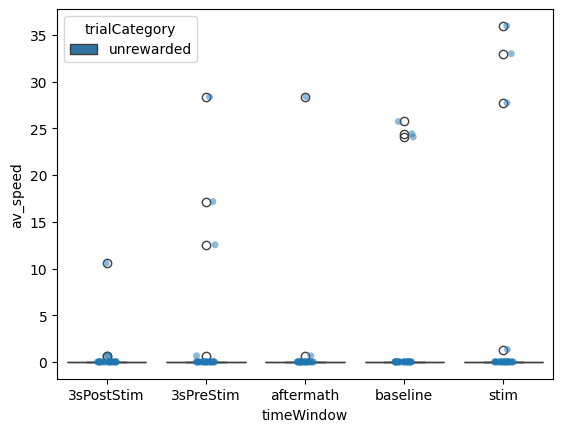

In [63]:
import seaborn as sns
fig, ax = plt.subplots()
sns.stripplot(x="timeWindow", y="av_speed", hue="trialCategory", data=df_long[df_long['trialCategory'].isin(['rewarded','unrewarded'])], legend=False, alpha=0.5, ax =ax)
sns.boxplot(x="timeWindow", y="av_speed", hue="trialCategory", data=df_long[df_long['trialCategory'].isin(['rewarded','unrewarded'])], ax=ax)



In [80]:
np.average(np.abs(behaviorData[1,0:secondsBefore*frameRate,trialIdx]), axis=0)df = pd.DataFrame.from_dict(data, orient='index')§a§

array([7.1300e+00, 6.8650e+00, 4.0000e-03, 7.8450e+00, 3.5050e+00,
       9.7230e+00, 9.3260e+00, 3.7360e+00, 1.2858e+01, 5.8200e-01,
       1.1931e+01, 6.1820e+00, 1.2150e+01, 1.3470e+01, 1.1287e+01,
       1.2332e+01, 1.6630e+00, 1.5000e-02, 6.8310e+00, 1.6820e+00,
       1.1260e+01, 5.8240e+00, 1.5511e+01, 1.2899e+01, 1.1635e+01,
       1.1551e+01, 7.6780e+00, 1.6492e+01, 8.5110e+00, 1.2488e+01,
       1.5881e+01, 1.5224e+01, 2.9960e+00, 1.3372e+01, 1.5020e+01,
       9.5230e+00, 2.0000e-03, 4.5810e+00, 1.9767e+01, 1.9206e+01,
       1.1135e+01, 0.0000e+00, 9.6490e+00, 1.5898e+01, 1.3089e+01,
       1.1184e+01, 8.7080e+00, 8.8310e+00, 5.0000e-03, 0.0000e+00,
       6.3060e+00, 0.0000e+00, 1.2172e+01, 8.9980e+00, 8.8410e+00,
       1.2073e+01, 6.4180e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       2.4860e+00, 7.6370e+00, 1.5508e+01, 1.4595e+01, 1.4588e+01,
       8.8530e+00, 8.0840e+00, 0.0000e+00, 1.1047e+01, 0.0000e+00,
       3.3690e+00, 9.2840e+00, 2.8740e+00, 1.0815e+01, 1.4695e

In [ ]:
'/Volumes/nerfceph/farrowlabwip2024/Data/02203/headfixed/m01/analysis/stimFileAnalysis/session=240524_1631'

In [67]:
stimFileAnalysis = mouse_context.analysis[".stimFileAnalysis/session=2203a_240603"].get().result
# behaviorData" : np.ndarray, shape (4, T, N)
#         Trial-aligned behavioral data where:
#             - Axis 0 (length 4): signal types
#                 [0] = trigger signal (s)
#                 [1] = forward movement (cm/s)
#                 [2] = side movement (cm/s)
#                 [3] = headdirection (Yaw (degree/s))
#             - Axis 1 (length T): time points per trial (T = frameRate * (secondsBefore + secondsAfter))
#             - Axis 2 (length N): number of trials
forwardVelocity = stimFileAnalysis['behaviorData'][1,:,:] #time x trials
lateralVelocity = stimFileAnalysis['behaviorData'][2,:,:] #time x trials

speed = np.full_like(forwardVelocity, fill_value=np.nan)
for t, (forwardV, lateralV) in enumerate(zip(forwardVelocity.T, lateralVelocity.T)):
    speed[:,t] = np.sqrt(forwardV**2 + lateralV**2)
    


KeyError: 'No such tagged analysis exists.'

# move files into folders

In [10]:
import os
import shutil

stim_path = '/Volumes/nerfceph/farrowlabwip2024/Data/02352/headfixed/m01/raw/StimFiles'
cam_path = '/Volumes/nerfceph/farrowlabwip2024/Data/02352/headfixed/m01/raw/Cam'

# Loop over folders in StimFiles
for folder_name in os.listdir(stim_path):
    stim_folder = os.path.join(stim_path, folder_name)
    if not os.path.isdir(stim_folder):
        continue  # Skip non-folders

    # Extract timestamp substring from folder name
    match_key = folder_name[11:22]  # 9 characters
    print(match_key)

    # Create corresponding folder in Cam
    cam_folder = os.path.join(cam_path, folder_name)
    os.makedirs(cam_folder, exist_ok=True)

    # Loop through files in the Cam root (not subfolders)
    for file_name in os.listdir(cam_path):
        file_path = os.path.join(cam_path,file_name)
        if os.path.isfile(file_path) and match_key in file_name:
            # Move the matching file into the new folder
            shutil.move(file_path, os.path.join(cam_folder, file_name))
            print(f'movie session {match_key} moved') 

240815_1432
movie session 240815_1432 moved
240828_1205
movie session 240828_1205 moved
240905_0944
movie session 240905_0944 moved
240811_1112
movie session 240811_1112 moved
240829_1215
movie session 240829_1215 moved
240906_1151
movie session 240906_1151 moved
240829_1159
movie session 240829_1159 moved
240819_1144
movie session 240819_1144 moved
240920_1006
movie session 240920_1006 moved
movie session 240920_1006 moved
240818_1224
240816_1442
movie session 240816_1442 moved
240916_0951
240812_1324
movie session 240812_1324 moved
240820_1141
movie session 240820_1141 moved
240822_1145
movie session 240822_1145 moved
240909_1313
movie session 240909_1313 moved
240813_1450
movie session 240813_1450 moved
240904_0944
240810_1021
movie session 240810_1021 moved
240902_0955
movie session 240902_0955 moved
240913_1144
movie session 240913_1144 moved
240815_1325
movie session 240815_1325 moved
240902_1156
240829_1012
movie session 240829_1012 moved
240805_1133
movie session 240805_1133 mo